# Quickstart: Building a GenAI powered Semantic Data Model with Intugle

This quickstart shows you how to use Intugle’s open-source library to transform fragmented datasets into a connected semantic model. The semantic model captures profiling, relationships, and business meaning of your data — making it instantly usable for exploration, search, and data product creation.

**What is a Semantic Model?**

A semantic model is an intelligent knowledge graph of your data. It connects tables, discovers relationships, and enriches them with business glossaries — so both data teams and business users can query with clarity, not complexity.

**Who is this for?**

*   **Data Engineers & Architects** often spend weeks manually profiling, classifying, and stitching together fragmented data assets. With Intugle, they can automate this process end-to-end, uncovering meaningful links and relationships to instantly generate a connected semantic layer.
*   **Data Analysts & Scientists** spend endless hours on data readiness and preparation before they can even start the real analysis. Intugle accelerates this by providing contextual intelligence, automatically generating SQL and reusable data products enriched with relationships and business meaning.
*   **Business Analysts & Decision Makers** are slowed down by constant dependence on technical teams for answers. Intugle removes this bottleneck by enabling natural language queries and semantic search, giving them trusted insights on demand.

**In this notebook, you will learn how to:**

*   **Generate Semantic Model** → The unified layer that transforms fragmented datasets, creating the foundation for connected intelligence.
    *   **1.1 Profile and classify data** → Analyze your data sources to understand their structure, data types, and other characteristics.
    *   **1.2 Discover links & relationships among data** → Reveal meaningful connections (PK & FK) across fragmented tables.
    *   **1.3 Generate a business glossary** → Create business-friendly terms and use them to query data with context.
    *   **1.4 Enable Semantic search** → Intelligent search that understands meaning, not just keywords—making data more accessible across both technical and business users.
    *   **1.5 Visualize semantic model** → Get access to enriched metadata of the semantic model and visualize your data and relationships.
*   **Build Unified Data Products** → Simply pick the attributes across your data tables, and let the toolkit auto-generate queries with all the required joins, transformations, and aggregations using the semantic layer. When executed, these queries produce reusable data products.

Before you start, make sure you install the **Intugle Data Tools**:

In [ ]:
CREATE OR REPLACE NETWORK RULE pypi_network_rule
MODE = EGRESS
TYPE = HOST_PORT
VALUE_LIST = ('pypi.org', 'pypi.python.org', 'pythonhosted.org', 'files.pythonhosted.org');

CREATE OR REPLACE NETWORK RULE nltk_network_rule
MODE = EGRESS
TYPE = HOST_PORT
VALUE_LIST = ('raw.githubusercontent.com');

CREATE OR REPLACE NETWORK RULE duckdb_download_rule
MODE = EGRESS
TYPE = HOST_PORT
VALUE_LIST = ('extensions.duckdb.org:80');

CREATE OR REPLACE NETWORK RULE openai_rule
  MODE = EGRESS
  TYPE = HOST_PORT
  VALUE_LIST = ('api.openai.com');



In [ ]:
CREATE OR REPLACE EXTERNAL ACCESS INTEGRATION intugle_integration
ALLOWED_NETWORK_RULES = (pypi_network_rule, nltk_network_rule, duckdb_download_rule, openai_rule)
ENABLED = true;


GRANT USAGE ON INTEGRATION intugle_integration TO ROLE SNOWFLAKE_LEARNING_ROLE;

In [ ]:
%pip install intugle[snowflake]

## 1. LLM Configuration

Before running the project, you need to configure a Large Language Model (LLM). This is used for tasks like generating business glossaries and predicting links between tables. For the semantic search feature, you will also need to set up Qdrant and provide an OpenAI API key. For detailed setup instructions, please refer to the [README.md](README.md) file.

You can configure the necessary services by setting the following environment variables:

*   `LLM_PROVIDER`: The LLM provider and model to use (e.g., `openai:gpt-3.5-turbo`). The format follows langchain's format for initializing chat models. Checkout how to specify your model [here](https://python.langchain.com/docs/integrations/chat/)
*   `API_KEY`: Your API key for the LLM provider. The exact name of the variable may vary from provider to provider (e.g., `OPENAI_API_KEY`, `ANTHROPIC_API_KEY`).

Here's an example of how to set these variables in your environment:

```bash
export LLM_PROVIDER="openai:gpt-3.5-turbo"
export OPENAI_API_KEY="your-openai-api-key"
```
Alternatively, you can set them in the notebook like this:

In [1]:
import os
from dotenv import load_dotenv


os.environ["LLM_PROVIDER"] = "openai:gpt-3.5-turbo"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"  # Replace with your actual key


# Load environment variables from .env file
load_dotenv(override=True)



True

> Currently the langchain packages for OpenAI, Anthropic and Gemini is installed by default. For additional models, make sure you have the integration packages installed. E.g. you should have langchain-deepseek installed to use a DeepSeek model. You can get these packages here: [LangChain Chat Models](https://python.langchain.com/docs/integrations/chat/)

## 2. Building the Semantic Model

The `SemanticModel` is the entry point for building your semantic layer. It takes a dictionary of datasets as input and performs the following steps:

1.  **Data Profiling:** Calculates statistics for each column, such as distinct count, uniqueness, and completeness.
2.  **Datatype Identification:** Identifies the data type of each column (e.g., integer, string, datetime).
3.  **Key Identification:** Identifies potential primary keys.
4.  **Glossary Generation:** Generates a business glossary for each column using an LLM.
5.  **Link Prediction:** Predicts the relationships (foreign keys) between tables.

Let's start by defining the datasets we want to use. The path shown below can be a local file path or a remote URL.

> For this demo, we will be using the technology manufacturing dataset which can be found under [sample_data/tech_manufacturing](https://github.com/Intugle/data-tools/blob/main/notebooks/quickstart_native_snowflake.ipynb) in the repo

In [2]:
def generate_config(table_name: str) -> str:
    """Append the base URL to the table name."""
    return {
        "identifier": table_name,
    }


table_names = \
[
    "CAMPAIGNS",
    "CAMPAIGN_SURVEY",
    "CUSTOMER_HIERARCHY",
    "CUSTOMERS",
    "DELIVERY_SURVEY",
    "EXPENSE",
    "INSTALL_BASE",
    "INVENTORY",
    "LOGISTICS",
    "NPS_SURVEY",
    "OPPORTUNITY",
    "ORDERS",
    "PROB_STATEMENT_ISSUE",
    "PRODUCT_FEATURE",
    "PRODUCT_HIERARCHY",
    "PRODUCTS",
    "RENEWALS",
    "RETURNS",
    "SERVICE_REQUESTS",
    "WEBSITE",
]


datasets = {table: generate_config(table) for table in table_names}

Now, let's use the `SemanticModel` to build our semantic layer:

> The `domain` parameter helps the LLM generate a more contextual business glossary. It specifies the industry domain that the dataset belongs to (e.g., "Healthcare", "Finance", "E-commerce").

In [3]:
from intugle import SemanticModel

# Initialize the semantic model
sm = SemanticModel(datasets, domain="Technology Manufacturing Company")

# Run the prediction
sm.build()

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "SnowflakeConnectionConfig" shadows an attribute in parent "SchemaBase"
  warnings.warn(
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "Source" shadows an attribute in parent "BaseResource"
  warnings.warn(


No active Snowpark session found. Creating a new session from profiles.yml.
CAMPAIGNS loaded
Found active Snowpark session. Using it for connection.
CAMPAIGN_SURVEY loaded
Found active Snowpark session. Using it for connection.
CUSTOMER_HIERARCHY loaded
Found active Snowpark session. Using it for connection.
CUSTOMERS loaded
Found active Snowpark session. Using it for connection.
DELIVERY_SURVEY loaded
Found active Snowpark session. Using it for connection.
EXPENSE loaded
Found active Snowpark session. Using it for connection.
INSTALL_BASE loaded
Found active Snowpark session. Using it for connection.
INVENTORY loaded
Found active Snowpark session. Using it for connection.
LOGISTICS loaded
Found active Snowpark session. Using it for connection.
NPS_SURVEY loaded
Found active Snowpark session. Using it for connection.
OPPORTUNITY loaded
Found active Snowpark session. Using it for connection.
ORDERS loaded
Found active Snowpark session. Using it for connection.
PROB_STATEMENT_ISSUE loade

Starting profiling and key identification stage...

Processing dataset: CAMPAIGNS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.12/pickle.py:1710: UserWarning: [01:34:40] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
[*] CAMPAIGNS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/i

Processing dataset: CAMPAIGN_SURVEY

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] CAMPAIGN_SURVEY:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] CAMPAIGN_SURVEY: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Processing dataset: CUSTOMER_HIERARCHY

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] CUSTOMER_HIERARCHY:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] CUSTOMER_HIERARCHY: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Processing dataset: CUSTOMERS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] CUSTOMERS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] CUSTOMERS: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Processing dataset: DELIVERY_SURVEY

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] DELIVERY_SURVEY:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] DELIVERY_SURVEY: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


Processing dataset: EXPENSE

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] EXPENSE:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] EXPENSE: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


Processing dataset: INSTALL_BASE

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] INSTALL_BASE:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] INSTALL_BASE: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Processing dataset: INVENTORY

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] INVENTORY:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] INVENTORY: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Processing dataset: LOGISTICS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] LOGISTICS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] LOGISTICS: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Processing dataset: NPS_SURVEY

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] NPS_SURVEY:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] NPS_SURVEY: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Processing dataset: OPPORTUNITY

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] OPPORTUNITY:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] OPPORTUNITY: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Processing dataset: ORDERS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] ORDERS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] ORDERS: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Processing dataset: PROB_STATEMENT_ISSUE

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] PROB_STATEMENT_ISSUE:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] PROB_STATEMENT_ISSUE: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Processing dataset: PRODUCT_FEATURE

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 8/8 [00:05<00:00,  1.60it/s]


Processing dataset: PRODUCT_HIERARCHY

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] PRODUCT_HIERARCHY:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] PRODUCT_HIERARCHY: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Processing dataset: PRODUCTS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] PRODUCTS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] PRODUCTS: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Processing dataset: RENEWALS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] RENEWALS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] RENEWALS: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Processing dataset: RETURNS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] RETURNS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] RETURNS: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Processing dataset: SERVICE_REQUESTS

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] SERVICE_REQUESTS:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[!] Error while llm invoke: Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2024-12-01-

Processing dataset: WEBSITE

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] WEBSITE:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/intugle/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
[*] WEBSITE: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Profiling and key identification complete.

Starting link prediction stage...

Dataset 'CAMPAIGNS' already processed. Skipping analysis.
Dataset 'CAMPAIGN_SURVEY' already processed. Skipping analysis.
Dataset 'CUSTOMER_HIERARCHY' already processed. Skipping analysis.
Dataset 'CUSTOMERS' already processed. Skipping analysis.
Dataset 'DELIVERY_SURVEY' already processed. Skipping analysis.
Dataset 'EXPENSE' already processed. Skipping analysis.
Dataset 'INSTALL_BASE' already processed. Skipping analysis.
Dataset 'INVENTORY' already processed. Skipping analysis.
Dataset 'LOGISTICS' already processed. Skipping analysis.
Dataset 'NPS_SURVEY' already processed. Skipping analysis.
Dataset 'OPPORTUNITY' already processed. Skipping analysis.
Dataset 'ORDERS' already processed. Skipping analysis.
Dataset 'PROB_STATEMENT_ISSUE' already processed. Skipping analysis.
Dataset 'PRODUCT_FEATURE' already processed. Skipping analysis.
Dataset 'PRODUCT_HIERARCHY' already processed. Skipping analysis.
Dataset 'PRODUCTS' already processed. Skipping analysis.
Dataset 'RENEWALS' already

[*] CAMPAIGNS <==> CAMPAIGN_SURVEY Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


Found 1 potential link(s).

--- Comparing 'CAMPAIGNS' <=> 'CUSTOMER_HIERARCHY' ---


[*] CAMPAIGNS <==> CUSTOMER_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'CUSTOMERS' ---


[*] CAMPAIGNS <==> CUSTOMERS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Found 1 potential link(s).

--- Comparing 'CAMPAIGNS' <=> 'DELIVERY_SURVEY' ---


[*] CAMPAIGNS <==> DELIVERY_SURVEY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'EXPENSE' ---


[*] CAMPAIGNS <==> EXPENSE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'INSTALL_BASE' ---


[*] CAMPAIGNS <==> INSTALL_BASE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'INVENTORY' ---


[*] CAMPAIGNS <==> INVENTORY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'LOGISTICS' ---


[*] CAMPAIGNS <==> LOGISTICS Runs:1: 100%|██████████| 1/1 [00:46<00:00, 46.46s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'NPS_SURVEY' ---


[*] CAMPAIGNS <==> NPS_SURVEY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'OPPORTUNITY' ---


[*] CAMPAIGNS <==> OPPORTUNITY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'ORDERS' ---


[*] CAMPAIGNS <==> ORDERS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'PROB_STATEMENT_ISSUE' ---


[*] CAMPAIGNS <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'PRODUCT_FEATURE' ---


[*] CAMPAIGNS <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'PRODUCT_HIERARCHY' ---


[*] CAMPAIGNS <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'PRODUCTS' ---


[*] CAMPAIGNS <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Found 1 potential link(s).

--- Comparing 'CAMPAIGNS' <=> 'RENEWALS' ---


[*] CAMPAIGNS <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'RETURNS' ---


[*] CAMPAIGNS <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'SERVICE_REQUESTS' ---


[*] CAMPAIGNS <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


No links found for this pair.

--- Comparing 'CAMPAIGNS' <=> 'WEBSITE' ---


[*] CAMPAIGNS <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Found 1 potential link(s).

--- Comparing 'CAMPAIGN_SURVEY' <=> 'CUSTOMER_HIERARCHY' ---


[*] CAMPAIGN_SURVEY <==> CUSTOMER_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'CUSTOMERS' ---


[*] CAMPAIGN_SURVEY <==> CUSTOMERS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'DELIVERY_SURVEY' ---


[*] CAMPAIGN_SURVEY <==> DELIVERY_SURVEY Runs:1: 100%|██████████| 1/1 [00:36<00:00, 36.66s/it]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'EXPENSE' ---


[*] CAMPAIGN_SURVEY <==> EXPENSE Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'INSTALL_BASE' ---


[*] CAMPAIGN_SURVEY <==> INSTALL_BASE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'INVENTORY' ---


[*] CAMPAIGN_SURVEY <==> INVENTORY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'LOGISTICS' ---


[*] CAMPAIGN_SURVEY <==> LOGISTICS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'NPS_SURVEY' ---


[*] CAMPAIGN_SURVEY <==> NPS_SURVEY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'OPPORTUNITY' ---


[*] CAMPAIGN_SURVEY <==> OPPORTUNITY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'ORDERS' ---


[*] CAMPAIGN_SURVEY <==> ORDERS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'PROB_STATEMENT_ISSUE' ---


[*] CAMPAIGN_SURVEY <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'PRODUCT_FEATURE' ---


[*] CAMPAIGN_SURVEY <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'PRODUCT_HIERARCHY' ---


[*] CAMPAIGN_SURVEY <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'PRODUCTS' ---


[*] CAMPAIGN_SURVEY <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'RENEWALS' ---


[*] CAMPAIGN_SURVEY <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'RETURNS' ---


[*] CAMPAIGN_SURVEY <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'SERVICE_REQUESTS' ---


[*] CAMPAIGN_SURVEY <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


No links found for this pair.

--- Comparing 'CAMPAIGN_SURVEY' <=> 'WEBSITE' ---


[*] CAMPAIGN_SURVEY <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'CUSTOMERS' ---


[*] CUSTOMER_HIERARCHY <==> CUSTOMERS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'DELIVERY_SURVEY' ---


[*] CUSTOMER_HIERARCHY <==> DELIVERY_SURVEY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'EXPENSE' ---


[*] CUSTOMER_HIERARCHY <==> EXPENSE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'INSTALL_BASE' ---


[*] CUSTOMER_HIERARCHY <==> INSTALL_BASE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'INVENTORY' ---


[*] CUSTOMER_HIERARCHY <==> INVENTORY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'LOGISTICS' ---


[*] CUSTOMER_HIERARCHY <==> LOGISTICS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'NPS_SURVEY' ---


[*] CUSTOMER_HIERARCHY <==> NPS_SURVEY Runs:1: 100%|██████████| 1/1 [00:38<00:00, 38.66s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'OPPORTUNITY' ---


[*] CUSTOMER_HIERARCHY <==> OPPORTUNITY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'ORDERS' ---


[*] CUSTOMER_HIERARCHY <==> ORDERS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'PROB_STATEMENT_ISSUE' ---


[*] CUSTOMER_HIERARCHY <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'PRODUCT_FEATURE' ---


[*] CUSTOMER_HIERARCHY <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'PRODUCT_HIERARCHY' ---


[*] CUSTOMER_HIERARCHY <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'PRODUCTS' ---


[*] CUSTOMER_HIERARCHY <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'RENEWALS' ---


[*] CUSTOMER_HIERARCHY <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'RETURNS' ---


[*] CUSTOMER_HIERARCHY <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'SERVICE_REQUESTS' ---


[*] CUSTOMER_HIERARCHY <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


No links found for this pair.

--- Comparing 'CUSTOMER_HIERARCHY' <=> 'WEBSITE' ---


[*] CUSTOMER_HIERARCHY <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'CUSTOMERS' <=> 'DELIVERY_SURVEY' ---


[*] CUSTOMERS <==> DELIVERY_SURVEY Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMERS' <=> 'EXPENSE' ---


[*] CUSTOMERS <==> EXPENSE Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMERS' <=> 'INSTALL_BASE' ---


[*] CUSTOMERS <==> INSTALL_BASE Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMERS' <=> 'INVENTORY' ---


[*] CUSTOMERS <==> INVENTORY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


No links found for this pair.

--- Comparing 'CUSTOMERS' <=> 'LOGISTICS' ---


[*] CUSTOMERS <==> LOGISTICS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMERS' <=> 'NPS_SURVEY' ---


[*] CUSTOMERS <==> NPS_SURVEY Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMERS' <=> 'OPPORTUNITY' ---


[*] CUSTOMERS <==> OPPORTUNITY Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMERS' <=> 'ORDERS' ---


[*] CUSTOMERS <==> ORDERS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMERS' <=> 'PROB_STATEMENT_ISSUE' ---


[*] CUSTOMERS <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:24<00:00, 24.87s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMERS' <=> 'PRODUCT_FEATURE' ---


[*] CUSTOMERS <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


No links found for this pair.

--- Comparing 'CUSTOMERS' <=> 'PRODUCT_HIERARCHY' ---


[*] CUSTOMERS <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


No links found for this pair.

--- Comparing 'CUSTOMERS' <=> 'PRODUCTS' ---


[*] CUSTOMERS <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'CUSTOMERS' <=> 'RENEWALS' ---


[*] CUSTOMERS <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMERS' <=> 'RETURNS' ---


[*] CUSTOMERS <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMERS' <=> 'SERVICE_REQUESTS' ---


[*] CUSTOMERS <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Found 1 potential link(s).

--- Comparing 'CUSTOMERS' <=> 'WEBSITE' ---


[*] CUSTOMERS <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'EXPENSE' ---


[*] DELIVERY_SURVEY <==> EXPENSE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'INSTALL_BASE' ---


[*] DELIVERY_SURVEY <==> INSTALL_BASE Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'INVENTORY' ---


[*] DELIVERY_SURVEY <==> INVENTORY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'LOGISTICS' ---


[*] DELIVERY_SURVEY <==> LOGISTICS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'NPS_SURVEY' ---


[*] DELIVERY_SURVEY <==> NPS_SURVEY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'OPPORTUNITY' ---


[*] DELIVERY_SURVEY <==> OPPORTUNITY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'ORDERS' ---


[*] DELIVERY_SURVEY <==> ORDERS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Found 1 potential link(s).

--- Comparing 'DELIVERY_SURVEY' <=> 'PROB_STATEMENT_ISSUE' ---


[*] DELIVERY_SURVEY <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'PRODUCT_FEATURE' ---


[*] DELIVERY_SURVEY <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:25<00:00, 25.58s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'PRODUCT_HIERARCHY' ---


[*] DELIVERY_SURVEY <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'PRODUCTS' ---


[*] DELIVERY_SURVEY <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


Found 1 potential link(s).

--- Comparing 'DELIVERY_SURVEY' <=> 'RENEWALS' ---


[*] DELIVERY_SURVEY <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'RETURNS' ---


[*] DELIVERY_SURVEY <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'SERVICE_REQUESTS' ---


[*] DELIVERY_SURVEY <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.68s/it]


No links found for this pair.

--- Comparing 'DELIVERY_SURVEY' <=> 'WEBSITE' ---


[*] DELIVERY_SURVEY <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'INSTALL_BASE' ---


[*] EXPENSE <==> INSTALL_BASE Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'INVENTORY' ---


[*] EXPENSE <==> INVENTORY Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


Found 1 potential link(s).

--- Comparing 'EXPENSE' <=> 'LOGISTICS' ---


[*] EXPENSE <==> LOGISTICS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'NPS_SURVEY' ---


[*] EXPENSE <==> NPS_SURVEY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'OPPORTUNITY' ---


[*] EXPENSE <==> OPPORTUNITY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'ORDERS' ---


[*] EXPENSE <==> ORDERS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'PROB_STATEMENT_ISSUE' ---


[*] EXPENSE <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:28<00:00, 28.39s/it]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'PRODUCT_FEATURE' ---


[*] EXPENSE <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'PRODUCT_HIERARCHY' ---


[*] EXPENSE <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'PRODUCTS' ---


[*] EXPENSE <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'RENEWALS' ---


[*] EXPENSE <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'RETURNS' ---


[*] EXPENSE <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'SERVICE_REQUESTS' ---


[*] EXPENSE <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


No links found for this pair.

--- Comparing 'EXPENSE' <=> 'WEBSITE' ---


[*] EXPENSE <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


No links found for this pair.

--- Comparing 'INSTALL_BASE' <=> 'INVENTORY' ---


[*] INSTALL_BASE <==> INVENTORY Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


No links found for this pair.

--- Comparing 'INSTALL_BASE' <=> 'LOGISTICS' ---


[*] INSTALL_BASE <==> LOGISTICS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


No links found for this pair.

--- Comparing 'INSTALL_BASE' <=> 'NPS_SURVEY' ---


[*] INSTALL_BASE <==> NPS_SURVEY Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


No links found for this pair.

--- Comparing 'INSTALL_BASE' <=> 'OPPORTUNITY' ---


[*] INSTALL_BASE <==> OPPORTUNITY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


No links found for this pair.

--- Comparing 'INSTALL_BASE' <=> 'ORDERS' ---


[*] INSTALL_BASE <==> ORDERS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


Found 1 potential link(s).

--- Comparing 'INSTALL_BASE' <=> 'PROB_STATEMENT_ISSUE' ---


[*] INSTALL_BASE <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


No links found for this pair.

--- Comparing 'INSTALL_BASE' <=> 'PRODUCT_FEATURE' ---


[*] INSTALL_BASE <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


No links found for this pair.

--- Comparing 'INSTALL_BASE' <=> 'PRODUCT_HIERARCHY' ---


[*] INSTALL_BASE <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:26<00:00, 26.48s/it]


No links found for this pair.

--- Comparing 'INSTALL_BASE' <=> 'PRODUCTS' ---


[*] INSTALL_BASE <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


Found 1 potential link(s).

--- Comparing 'INSTALL_BASE' <=> 'RENEWALS' ---


[*] INSTALL_BASE <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


No links found for this pair.

--- Comparing 'INSTALL_BASE' <=> 'RETURNS' ---


[*] INSTALL_BASE <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


No links found for this pair.

--- Comparing 'INSTALL_BASE' <=> 'SERVICE_REQUESTS' ---


[*] INSTALL_BASE <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.14s/it]


No links found for this pair.

--- Comparing 'INSTALL_BASE' <=> 'WEBSITE' ---


[*] INSTALL_BASE <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


No links found for this pair.

--- Comparing 'INVENTORY' <=> 'LOGISTICS' ---


[*] INVENTORY <==> LOGISTICS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


No links found for this pair.

--- Comparing 'INVENTORY' <=> 'NPS_SURVEY' ---


[*] INVENTORY <==> NPS_SURVEY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'INVENTORY' <=> 'OPPORTUNITY' ---


[*] INVENTORY <==> OPPORTUNITY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


No links found for this pair.

--- Comparing 'INVENTORY' <=> 'ORDERS' ---


[*] INVENTORY <==> ORDERS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


No links found for this pair.

--- Comparing 'INVENTORY' <=> 'PROB_STATEMENT_ISSUE' ---


[*] INVENTORY <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


No links found for this pair.

--- Comparing 'INVENTORY' <=> 'PRODUCT_FEATURE' ---


[*] INVENTORY <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


No links found for this pair.

--- Comparing 'INVENTORY' <=> 'PRODUCT_HIERARCHY' ---


[*] INVENTORY <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


No links found for this pair.

--- Comparing 'INVENTORY' <=> 'PRODUCTS' ---


[*] INVENTORY <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Found 1 potential link(s).

--- Comparing 'INVENTORY' <=> 'RENEWALS' ---


[*] INVENTORY <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


No links found for this pair.

--- Comparing 'INVENTORY' <=> 'RETURNS' ---


[*] INVENTORY <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:22<00:00, 22.58s/it]


No links found for this pair.

--- Comparing 'INVENTORY' <=> 'SERVICE_REQUESTS' ---


[*] INVENTORY <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


No links found for this pair.

--- Comparing 'INVENTORY' <=> 'WEBSITE' ---


[*] INVENTORY <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


No links found for this pair.

--- Comparing 'LOGISTICS' <=> 'NPS_SURVEY' ---


[*] LOGISTICS <==> NPS_SURVEY Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


No links found for this pair.

--- Comparing 'LOGISTICS' <=> 'OPPORTUNITY' ---


[*] LOGISTICS <==> OPPORTUNITY Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it]


No links found for this pair.

--- Comparing 'LOGISTICS' <=> 'ORDERS' ---


[*] LOGISTICS <==> ORDERS Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


Found 1 potential link(s).

--- Comparing 'LOGISTICS' <=> 'PROB_STATEMENT_ISSUE' ---


[*] LOGISTICS <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


No links found for this pair.

--- Comparing 'LOGISTICS' <=> 'PRODUCT_FEATURE' ---


[*] LOGISTICS <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


No links found for this pair.

--- Comparing 'LOGISTICS' <=> 'PRODUCT_HIERARCHY' ---


[*] LOGISTICS <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


No links found for this pair.

--- Comparing 'LOGISTICS' <=> 'PRODUCTS' ---


[*] LOGISTICS <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


No links found for this pair.

--- Comparing 'LOGISTICS' <=> 'RENEWALS' ---


[*] LOGISTICS <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


No links found for this pair.

--- Comparing 'LOGISTICS' <=> 'RETURNS' ---


[*] LOGISTICS <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


No links found for this pair.

--- Comparing 'LOGISTICS' <=> 'SERVICE_REQUESTS' ---


[*] LOGISTICS <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


No links found for this pair.

--- Comparing 'LOGISTICS' <=> 'WEBSITE' ---


[*] LOGISTICS <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


No links found for this pair.

--- Comparing 'NPS_SURVEY' <=> 'OPPORTUNITY' ---


[*] NPS_SURVEY <==> OPPORTUNITY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


No links found for this pair.

--- Comparing 'NPS_SURVEY' <=> 'ORDERS' ---


[*] NPS_SURVEY <==> ORDERS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


No links found for this pair.

--- Comparing 'NPS_SURVEY' <=> 'PROB_STATEMENT_ISSUE' ---


[*] NPS_SURVEY <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.19s/it]


No links found for this pair.

--- Comparing 'NPS_SURVEY' <=> 'PRODUCT_FEATURE' ---


[*] NPS_SURVEY <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


No links found for this pair.

--- Comparing 'NPS_SURVEY' <=> 'PRODUCT_HIERARCHY' ---


[*] NPS_SURVEY <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:19<00:00, 19.72s/it]


No links found for this pair.

--- Comparing 'NPS_SURVEY' <=> 'PRODUCTS' ---


[*] NPS_SURVEY <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


No links found for this pair.

--- Comparing 'NPS_SURVEY' <=> 'RENEWALS' ---


[*] NPS_SURVEY <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


No links found for this pair.

--- Comparing 'NPS_SURVEY' <=> 'RETURNS' ---


[*] NPS_SURVEY <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


Found 1 potential link(s).

--- Comparing 'NPS_SURVEY' <=> 'SERVICE_REQUESTS' ---


[*] NPS_SURVEY <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


Found 1 potential link(s).

--- Comparing 'NPS_SURVEY' <=> 'WEBSITE' ---


[*] NPS_SURVEY <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


No links found for this pair.

--- Comparing 'OPPORTUNITY' <=> 'ORDERS' ---


[*] OPPORTUNITY <==> ORDERS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


No links found for this pair.

--- Comparing 'OPPORTUNITY' <=> 'PROB_STATEMENT_ISSUE' ---


[*] OPPORTUNITY <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


No links found for this pair.

--- Comparing 'OPPORTUNITY' <=> 'PRODUCT_FEATURE' ---


[*] OPPORTUNITY <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'OPPORTUNITY' <=> 'PRODUCT_HIERARCHY' ---


[*] OPPORTUNITY <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


No links found for this pair.

--- Comparing 'OPPORTUNITY' <=> 'PRODUCTS' ---


[*] OPPORTUNITY <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


No links found for this pair.

--- Comparing 'OPPORTUNITY' <=> 'RENEWALS' ---


[*] OPPORTUNITY <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


No links found for this pair.

--- Comparing 'OPPORTUNITY' <=> 'RETURNS' ---


[*] OPPORTUNITY <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


No links found for this pair.

--- Comparing 'OPPORTUNITY' <=> 'SERVICE_REQUESTS' ---


[*] OPPORTUNITY <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


No links found for this pair.

--- Comparing 'OPPORTUNITY' <=> 'WEBSITE' ---


[*] OPPORTUNITY <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


No links found for this pair.

--- Comparing 'ORDERS' <=> 'PROB_STATEMENT_ISSUE' ---


[*] ORDERS <==> PROB_STATEMENT_ISSUE Runs:1: 100%|██████████| 1/1 [00:26<00:00, 26.17s/it]


No links found for this pair.

--- Comparing 'ORDERS' <=> 'PRODUCT_FEATURE' ---


[*] ORDERS <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:09<00:00,  9.00s/it]


No links found for this pair.

--- Comparing 'ORDERS' <=> 'PRODUCT_HIERARCHY' ---


[*] ORDERS <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


No links found for this pair.

--- Comparing 'ORDERS' <=> 'PRODUCTS' ---


[*] ORDERS <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.80s/it]


Found 1 potential link(s).

--- Comparing 'ORDERS' <=> 'RENEWALS' ---


[*] ORDERS <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


Found 1 potential link(s).

--- Comparing 'ORDERS' <=> 'RETURNS' ---


[*] ORDERS <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


Found 1 potential link(s).

--- Comparing 'ORDERS' <=> 'SERVICE_REQUESTS' ---


[*] ORDERS <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]


Found 1 potential link(s).

--- Comparing 'ORDERS' <=> 'WEBSITE' ---


[*] ORDERS <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


No links found for this pair.

--- Comparing 'PROB_STATEMENT_ISSUE' <=> 'PRODUCT_FEATURE' ---


[*] PROB_STATEMENT_ISSUE <==> PRODUCT_FEATURE Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


No links found for this pair.

--- Comparing 'PROB_STATEMENT_ISSUE' <=> 'PRODUCT_HIERARCHY' ---


[*] PROB_STATEMENT_ISSUE <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


No links found for this pair.

--- Comparing 'PROB_STATEMENT_ISSUE' <=> 'PRODUCTS' ---


[*] PROB_STATEMENT_ISSUE <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


Found 1 potential link(s).

--- Comparing 'PROB_STATEMENT_ISSUE' <=> 'RENEWALS' ---


[*] PROB_STATEMENT_ISSUE <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


No links found for this pair.

--- Comparing 'PROB_STATEMENT_ISSUE' <=> 'RETURNS' ---


[*] PROB_STATEMENT_ISSUE <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


No links found for this pair.

--- Comparing 'PROB_STATEMENT_ISSUE' <=> 'SERVICE_REQUESTS' ---


[*] PROB_STATEMENT_ISSUE <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Found 1 potential link(s).

--- Comparing 'PROB_STATEMENT_ISSUE' <=> 'WEBSITE' ---


[*] PROB_STATEMENT_ISSUE <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


No links found for this pair.

--- Comparing 'PRODUCT_FEATURE' <=> 'PRODUCT_HIERARCHY' ---


[*] PRODUCT_FEATURE <==> PRODUCT_HIERARCHY Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


No links found for this pair.

--- Comparing 'PRODUCT_FEATURE' <=> 'PRODUCTS' ---


[*] PRODUCT_FEATURE <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


Found 1 potential link(s).

--- Comparing 'PRODUCT_FEATURE' <=> 'RENEWALS' ---


[*] PRODUCT_FEATURE <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


No links found for this pair.

--- Comparing 'PRODUCT_FEATURE' <=> 'RETURNS' ---


[*] PRODUCT_FEATURE <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:16<00:00, 16.37s/it]


No links found for this pair.

--- Comparing 'PRODUCT_FEATURE' <=> 'SERVICE_REQUESTS' ---


[*] PRODUCT_FEATURE <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


No links found for this pair.

--- Comparing 'PRODUCT_FEATURE' <=> 'WEBSITE' ---


[*] PRODUCT_FEATURE <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


No links found for this pair.

--- Comparing 'PRODUCT_HIERARCHY' <=> 'PRODUCTS' ---


[*] PRODUCT_HIERARCHY <==> PRODUCTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


Found 1 potential link(s).

--- Comparing 'PRODUCT_HIERARCHY' <=> 'RENEWALS' ---


[*] PRODUCT_HIERARCHY <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.44s/it]


No links found for this pair.

--- Comparing 'PRODUCT_HIERARCHY' <=> 'RETURNS' ---


[*] PRODUCT_HIERARCHY <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


No links found for this pair.

--- Comparing 'PRODUCT_HIERARCHY' <=> 'SERVICE_REQUESTS' ---


[*] PRODUCT_HIERARCHY <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.32s/it]


No links found for this pair.

--- Comparing 'PRODUCT_HIERARCHY' <=> 'WEBSITE' ---


[*] PRODUCT_HIERARCHY <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


No links found for this pair.

--- Comparing 'PRODUCTS' <=> 'RENEWALS' ---


[*] PRODUCTS <==> RENEWALS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Found 1 potential link(s).

--- Comparing 'PRODUCTS' <=> 'RETURNS' ---


[*] PRODUCTS <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


Found 1 potential link(s).

--- Comparing 'PRODUCTS' <=> 'SERVICE_REQUESTS' ---


[*] PRODUCTS <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


Found 1 potential link(s).

--- Comparing 'PRODUCTS' <=> 'WEBSITE' ---


[*] PRODUCTS <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


No links found for this pair.

--- Comparing 'RENEWALS' <=> 'RETURNS' ---


[*] RENEWALS <==> RETURNS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


No links found for this pair.

--- Comparing 'RENEWALS' <=> 'SERVICE_REQUESTS' ---


[*] RENEWALS <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


No links found for this pair.

--- Comparing 'RENEWALS' <=> 'WEBSITE' ---


[*] RENEWALS <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


No links found for this pair.

--- Comparing 'RETURNS' <=> 'SERVICE_REQUESTS' ---


[*] RETURNS <==> SERVICE_REQUESTS Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


Found 1 potential link(s).

--- Comparing 'RETURNS' <=> 'WEBSITE' ---


[*] RETURNS <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


No links found for this pair.

--- Comparing 'SERVICE_REQUESTS' <=> 'WEBSITE' ---


[*] SERVICE_REQUESTS <==> WEBSITE Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

No links found for this pair.


Link prediction complete.

Starting business glossary generation stage...

Generating glossary for dataset: CAMPAIGNS

100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


Generating glossary for dataset: CAMPAIGN_SURVEY

100%|██████████| 9/9 [00:11<00:00,  1.29s/it]


Generating glossary for dataset: CUSTOMER_HIERARCHY

100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Generating glossary for dataset: CUSTOMERS

100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


Generating glossary for dataset: DELIVERY_SURVEY

100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


Generating glossary for dataset: EXPENSE

100%|██████████| 11/11 [00:14<00:00,  1.31s/it]


Generating glossary for dataset: INSTALL_BASE

100%|██████████| 13/13 [00:16<00:00,  1.26s/it]


Generating glossary for dataset: INVENTORY

100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


Generating glossary for dataset: LOGISTICS

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


Generating glossary for dataset: NPS_SURVEY

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Generating glossary for dataset: OPPORTUNITY

100%|██████████| 12/12 [00:15<00:00,  1.25s/it]


Generating glossary for dataset: ORDERS

100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Generating glossary for dataset: PROB_STATEMENT_ISSUE

100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


Generating glossary for dataset: PRODUCT_FEATURE

100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Generating glossary for dataset: PRODUCT_HIERARCHY

100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Generating glossary for dataset: PRODUCTS

100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Generating glossary for dataset: RENEWALS

100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Generating glossary for dataset: RETURNS

100%|██████████| 11/11 [00:14<00:00,  1.33s/it]


Generating glossary for dataset: SERVICE_REQUESTS

100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


Generating glossary for dataset: WEBSITE

100%|██████████| 9/9 [00:12<00:00,  1.43s/it]


Business glossary generation complete.

Initializing semantic search...


ERROR:intugle.core.vector_store.qdrant:AsyncQdrantService: Couldn't create collection, reason: All connection attempts failed


## 3. Accessing Enriched Metadata

Now that the semantic model is built, you can easily access the enriched metadata for each dataset.

### Accessing a Dataset

You can access a specific dataset by its name from the `sm.datasets` dictionary:

In [4]:
products_dataset = sm.datasets['PRODUCTS']
products_dataset.profiling_df

,column_name,table_name,business_name,datatype_l1,datatype_l2,business_glossary,business_tags,count,null_count,distinct_count,uniqueness,completeness,sample_data
0,PRODUCT_ID,PRODUCTS,product_id,alphanumeric,L2OutputTypes.dimension,Serves as a unique identifier for individual p...,"[Product Identification, Inventory Tracking, M...",1000,0,1000,1.000,1.0,"[PROD-11993, PROD-11216, PROD-11477, PROD-1125..."
1,PRODUCT_NAME,PRODUCTS,product_name,alphanumeric,L2OutputTypes.dimension,Identifies the name assigned to a product offe...,"[Product Portfolio, Technology Solutions, Bran...",1000,0,5,0.005,1.0,"[Insight360, CoreAnalytics, NetConnect, CloudE..."
2,PRODUCT_CATEGORY,PRODUCTS,product_category,close_ended_text,L2OutputTypes.dimension,Groups products based on their functional or m...,"[Product Classification, Technology Domain, Bu...",1000,0,5,0.005,1.0,"[IoT, Networking, Security, Cloud Platform, An..."
3,PRODUCT_STATUS,PRODUCTS,product_status,close_ended_text,L2OutputTypes.dimension,Indicates the current lifecycle phase of a pro...,"[Lifecycle Management, Product Development Sta...",1000,0,5,0.005,1.0,"[Retired, GA (General Availability), In Develo..."
4,"""r&d initiation date""",PRODUCTS,r_d_initiation_date,date & time,L2OutputTypes.dimension,Indicates the date and time when the research ...,"[Product Development Timeline, Research And De...",1000,0,777,0.777,1.0,"[2022-10-09, 2021-02-21, 2022-05-03, 2021-08-2..."
5,"""r&d stage""",PRODUCTS,r_d_stage,close_ended_text,L2OutputTypes.dimension,Indicates the current phase of development for...,"[Product Development Lifecycle, Innovation Man...",1000,0,5,0.005,1.0,"[Prototype, Pre-Launch, Enhancement, Testing, ..."
6,LAUNCH_STATUS,PRODUCTS,launch_status,close_ended_text,L2OutputTypes.dimension,Indicates the current progress or outcome of a...,"[Product Lifecycle, Launch Planning, Status Tr...",1000,0,5,0.005,1.0,"[Planned, Not Launched, Launched, In Pipeline,..."
7,LAUNCH_DATE,PRODUCTS,launch_date,date & time,L2OutputTypes.dimension,Indicates the date and time when a product bec...,"[Product Launch Timeline, Go-To-Market Strateg...",1000,0,659,0.659,1.0,"[2023-08-06, 2024-08-05, 2025-01-27, 2024-08-2..."
8,PM_NAME,PRODUCTS,pm_name,close_ended_text,L2OutputTypes.dimension,Identifies the individual responsible for mana...,"[Product Manager, Employee Name, Responsible P...",1000,0,994,0.994,1.0,"[Darrell Palmer, Mrs. Rachel Davidson, Gregory..."
9,"""product cost ($)""",PRODUCTS,product_cost,integer,L2OutputTypes.measure,Tracks the monetary expense incurred to produc...,"[Product Pricing, Cost Analysis, Manufacturing...",1000,0,998,0.998,1.0,"[218276, 364894, 186668, 350676, 597190, 31221..."


The profiling results can be accessed through the `profiling_df` property of the `DataSet` object. It's a pandas DataFrame that you can easily explore. 
> The business glossary is also available in the `profiling_df`:

### Visualizing Relationships

The `SemanticModel` automatically discovers the relationships between your tables. You can access the predicted links as a list of `PredictedLink` objects:

In [5]:
sm.links

[PredictedLink(from_dataset='CAMPAIGNS', from_column='CAMPAIGN_ID', to_dataset='CAMPAIGN_SURVEY', to_column='CAMP_ID', intersect_count=635, intersect_ratio_from_col=0.635, intersect_ratio_to_col=1.0, accuracy=1.0),
 PredictedLink(from_dataset='CAMPAIGNS', from_column='PROSPECT_ID', to_dataset='CUSTOMERS', to_column='C_ID', intersect_count=622, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.622, accuracy=1.0),
 PredictedLink(from_dataset='CAMPAIGNS', from_column='PROD_ID', to_dataset='PRODUCTS', to_column='PRODUCT_ID', intersect_count=633, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.633, accuracy=1.0),
 PredictedLink(from_dataset='CAMPAIGNS', from_column='CAMPAIGN_ID', to_dataset='WEBSITE', to_column='CMGN_ID', intersect_count=618, intersect_ratio_from_col=0.618, intersect_ratio_to_col=1.0, accuracy=1.0),
 PredictedLink(from_dataset='CUSTOMER_HIERARCHY', from_column='PARTY_ID', to_dataset='CUSTOMERS', to_column='C_ID', intersect_count=616, intersect_ratio_from_col=1.0

You can also visualize these relationships as a graph. In case you run into an error, make sure you install/upgrade your ipykernel package:
> %pip install --upgrade ipykernel

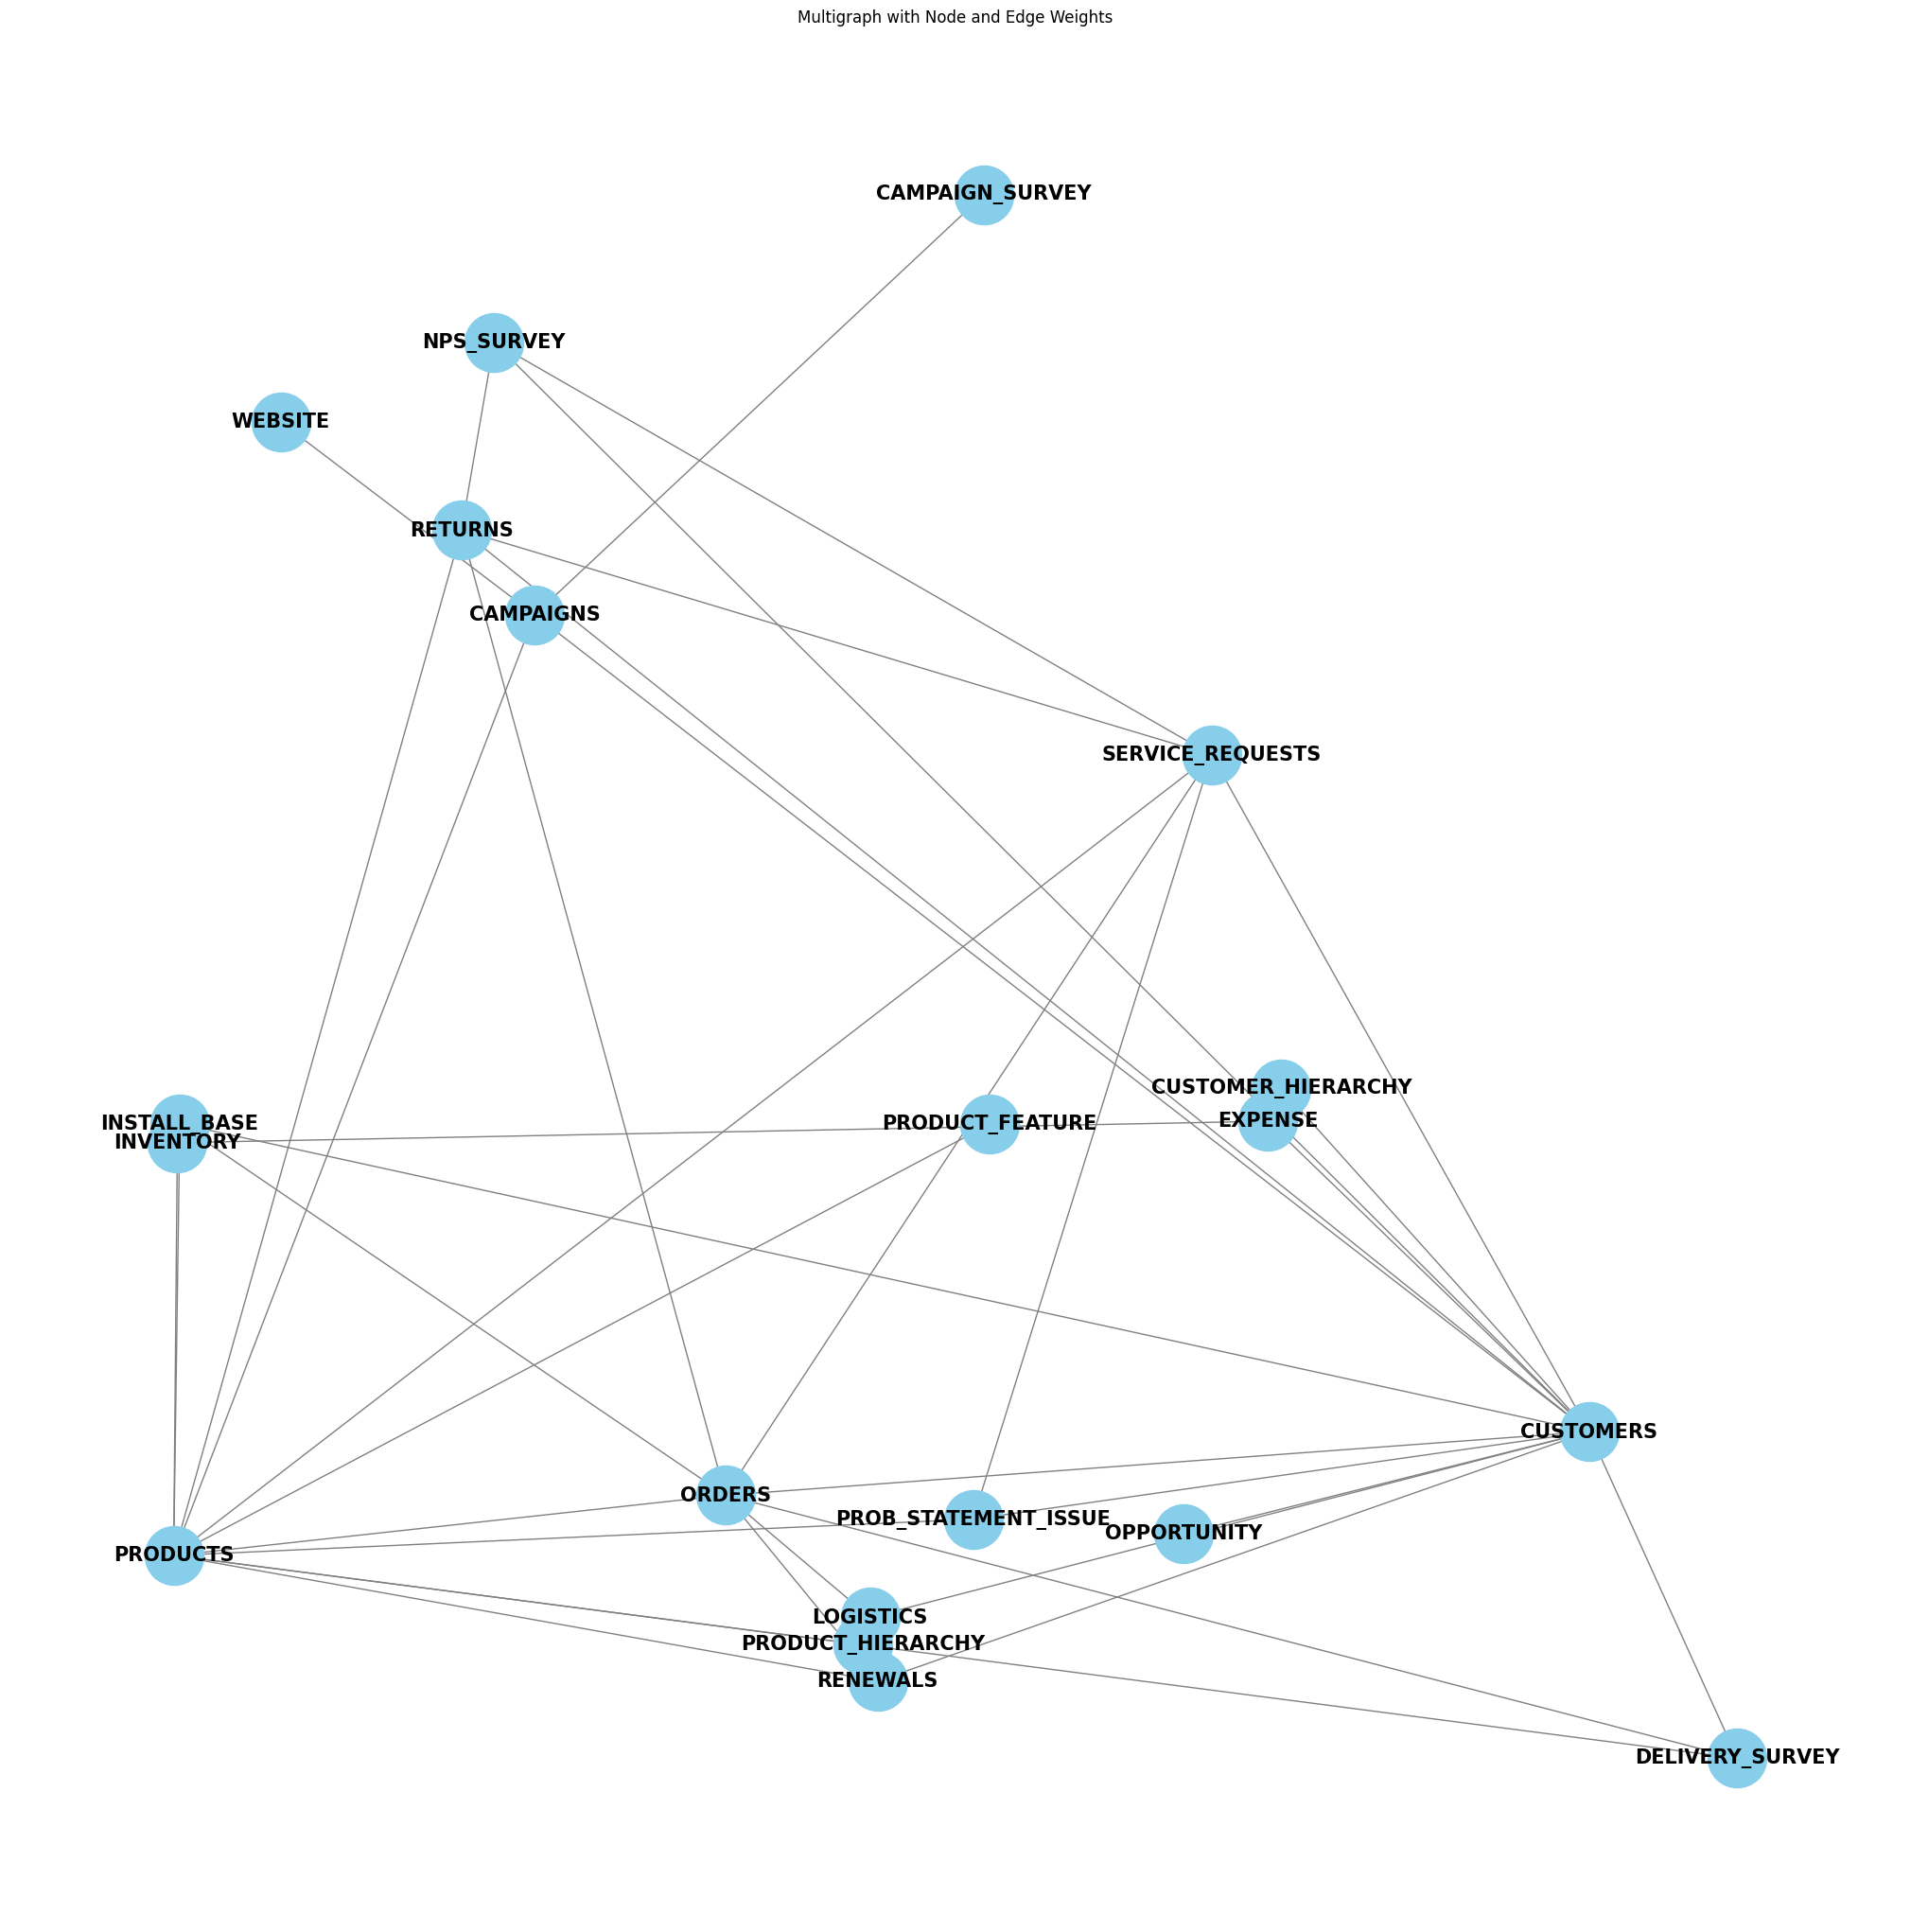

In [6]:
sm.visualize()  # To visualize the relationships as a graph

## 4. The Semantic Layer

The SemanticModel results are used to generate YAML files which are saved automatically. These files defines the semantic layer, including the models (tables) and their relationships. 

By default, these files are saved in the current working directory. You can configure this path by setting the `PROJECT_BASE` environment variable.

## 5. Deploying to Snowflake

Syncs the business glossaries with the source tables. Creates a semantic view in Snowflake complete with business glossaries, datatypes and relationships

In [7]:
sm.deploy('snowflake')

Starting deployment to 'snowflake' based on project YAML files...

Found active Snowpark session. Using it for connection.
Syncing metadata to Snowflake tables...
Metadata sync complete.
Deploying semantic model view 'intugle_semantic_view' to Snowflake...
Semantic model view 'intugle_semantic_view' deployed successfully.


Successfully deployed semantic model to 'snowflake'.

You can also just create the YAML compatible with Snowflake Semantic Views:

In [ ]:
sm.export(format="snowflake", path="snowflake_semantic_model.yml")

>Now that you have deployed a Semantic View, you can use **Snowflake Cortex Analyst** to **converse with your data** using natural language. Cortex Analyst leverages the relationships and context defined in your Semantic View to answer questions without requiring you to write SQL.
To get started, navigate to **AI & ML** -> **Cortex Analyst** in the **Snowflake UI** and select your newly created view.

## 6. Data Product Creation

The semantic layer serves as a foundation for the DataProduct, which streamlines the creation of reusable data products. This allows you
to encapsulate business logic and create standardized, trustworthy data assets that can be easily shared and reused across different teams and 
applications.

Let's define the model for the data product we want to build:

In [9]:
data_product_config = \
{
    "name": "customer_kpi_summary",
    "fields": [
        {
            "id": "CUSTOMERS.C_ID",
            "name": "c_id"
        },
        {
            "id": "CUSTOMERS.CUSTOMER_NAME",
            "name": "customer_name"
        },
        {
            "id": "CUSTOMER_HIERARCHY.\"global / parent account\"",
            "name": "global_parent_account"
        },
        {
            "id": "CUSTOMER_HIERARCHY.REGION",
            "name": "region"
        },
        {
            "id": "CUSTOMER_HIERARCHY.\"global / local entity\"",
            "name": "global_local_entity"
        },
        {
            "id": "PRODUCTS.PRODUCT_NAME",
            "name": "product_name"
        },
        {
            "id": "ORDERS.\"order value ($)\"",
            "name": "sum_order_value",
            "category": "measure",
            "measure_func": "sum"
        },
        {
            "id": "ORDERS.ORDER_ID",
            "name": "count_distinct_order_id",
            "category": "measure",
            "measure_func": "count"
        },
        {
            "id": "ORDERS.ORDER_QTY",
            "name": "sum_order_qty",
            "category": "measure",
            "measure_func": "sum"
        },
        {
            "id": "SERVICE_REQUESTS.SR_ID",
            "name": "count_distinct_sr_id",
            "category": "measure",
            "measure_func": "count"
        },
        {
            "id": "SERVICE_REQUESTS.PROD_ID",
            "name": "count_distinct_prod_id",
            "category": "measure",
            "measure_func": "count"
        },
        {
            "id": "RETURNS.R_ORDER_ID",
            "name": "count_distinct_r_order_id",
            "category": "measure",
            "measure_func": "count"
        },
        {
            "id": "NPS_SURVEY.SURVEY_SCORE",
            "name": "sum_survey_score",
            "category": "measure",
            "measure_func": "sum"
        }
    ]
}

> Checkout the Intugle documentation to learn how to add sorting and filters to your data product

Now, let's use the `DataProduct` to generate the data product:

In [10]:
from intugle import DataProduct

# Create a DataProduct
dp = DataProduct()

# Generate the data product
data_product = dp.build(data_product_config)

data_product.to_df()

Found active Snowpark session. Using it for connection.
Found existing YAML for 'PRODUCTS'. Checking for staleness.
PRODUCTS loaded
Found active Snowpark session. Using it for connection.
Found existing YAML for 'INVENTORY'. Checking for staleness.
INVENTORY loaded
Found active Snowpark session. Using it for connection.
Found existing YAML for 'CAMPAIGNS'. Checking for staleness.
CAMPAIGNS loaded
Found active Snowpark session. Using it for connection.
Found existing YAML for 'CUSTOMER_HIERARCHY'. Checking for staleness.
CUSTOMER_HIERARCHY loaded
Found active Snowpark session. Using it for connection.
Found existing YAML for 'PRODUCT_HIERARCHY'. Checking for staleness.
PRODUCT_HIERARCHY loaded
Found active Snowpark session. Using it for connection.
Found existing YAML for 'INSTALL_BASE'. Checking for staleness.
INSTALL_BASE loaded
Found active Snowpark session. Using it for connection.
Found existing YAML for 'RENEWALS'. Checking for staleness.
RENEWALS loaded
Found active Snowpark sess

,C_ID,CUSTOMER_NAME,GLOBAL_PARENT_ACCOUNT,REGION,GLOBAL_LOCAL_ENTITY,PRODUCT_NAME,SUM_ORDER_VALUE,COUNT_DISTINCT_ORDER_ID,SUM_ORDER_QTY,COUNT_DISTINCT_SR_ID,COUNT_DISTINCT_PROD_ID,COUNT_DISTINCT_R_ORDER_ID,SUM_SURVEY_SCORE
0,CUST-10109,Johnston Inc,Mendoza-Singleton Holdings,Middle East,Local,NetConnect,27916.0,4,28.0,4,4,4,10
1,CUST-10136,Freeman-Hunt,Stout Holdings,North America,Global,Insight360,57350.0,4,95.0,4,4,4,24
2,CUST-10791,"Hobbs, Carlson and Hughes",Baker Holdings,APAC,Local,DataSphere,29685.0,2,57.0,2,2,2,0
3,CUST-10293,"Johnson, Harrison and Farrell",None,None,None,CloudEdge,13315.0,1,10.0,1,1,1,8
4,CUST-10658,"Hill, Brown and Jackson",None,None,None,CloudEdge,200648.0,14,344.0,14,14,14,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,CUST-10082,"Vargas, Smith and Walker",Rodriguez Holdings,North America,Global,None,NaN,0,NaN,0,0,0,19
1085,CUST-10057,Kemp Inc,"Williams, Holdings",North America,Global,None,NaN,0,NaN,0,0,0,6
1086,CUST-10075,"Terry, Robertson and Pruitt",Ibarra Holdings,APAC,Global,None,NaN,0,NaN,0,0,0,6
1087,CUST-10714,"Vaughan, Erickson and Navarro",West-Day Holdings,North America,Global,None,NaN,0,NaN,0,0,0,3


The `build` function returns a `DataSet` object. You can also view the generated SQL query used for creating the data product:

In [11]:
# The generated SQL query
data_product.sql_query

'SELECT "CUSTOMERS"."C_ID" as c_id, "CUSTOMERS"."CUSTOMER_NAME" as customer_name, "CUSTOMER_HIERARCHY".""global / parent account"" as global_parent_account, "CUSTOMER_HIERARCHY"."REGION" as region, "CUSTOMER_HIERARCHY".""global / local entity"" as global_local_entity, "PRODUCTS"."PRODUCT_NAME" as product_name, sum("ORDERS".""order value ($)"") as sum_order_value, count("ORDERS"."ORDER_ID") as count_distinct_order_id, sum("ORDERS"."ORDER_QTY") as sum_order_qty, count("SERVICE_REQUESTS"."SR_ID") as count_distinct_sr_id, count("SERVICE_REQUESTS"."PROD_ID") as count_distinct_prod_id, count("RETURNS"."R_ORDER_ID") as count_distinct_r_order_id, sum("NPS_SURVEY"."SURVEY_SCORE") as sum_survey_score FROM NPS_SURVEY LEFT JOIN CUSTOMERS ON "CUSTOMERS"."C_ID" = "NPS_SURVEY"."CUSTOMER_ID" LEFT JOIN CUSTOMER_HIERARCHY ON "CUSTOMER_HIERARCHY"."PARTY_ID" = "CUSTOMERS"."C_ID" LEFT JOIN CAMPAIGNS ON "CAMPAIGNS"."PROSPECT_ID" = "CUSTOMERS"."C_ID" LEFT JOIN PRODUCTS ON "CAMPAIGNS"."PROD_ID" = "PRODUCTS"."

### Enriching the Data Product

The `data_product` is in itself a DataSet object. Hence we can run generate glossaries for it as well. 

In [12]:
data_product.run(domain="Technology Manufacturing Company")
data_product.profiling_df

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 13/13 [00:17<00:00,  1.33s/it]


,column_name,table_name,business_name,datatype_l1,datatype_l2,business_glossary,business_tags,count,null_count,distinct_count,uniqueness,completeness,sample_data
0,C_ID,customer_kpi_summary,c_id,alphanumeric,L2OutputTypes.dimension,Identifies individual customers for tracking p...,"[Customer Identifier, Customer Record Tracking...",1089,0,615,0.564738,1.000000,"[CUST-10196, CUST-10362, CUST-10696, CUST-1044..."
1,CUSTOMER_NAME,customer_kpi_summary,customer_name,close_ended_text,L2OutputTypes.dimension,Identifies the name of the organization or ent...,"[Customer Identification, Business Entity Name...",1089,0,599,0.550046,1.000000,"[Hampton, Mcclain and Arroyo, Robinson-Warner,..."
2,GLOBAL_PARENT_ACCOUNT,customer_kpi_summary,global_parent_account,close_ended_text,L2OutputTypes.dimension,Identifies the overarching corporate entity as...,"[Global Account Hierarchy, Parent Company Iden...",1089,299,410,0.376492,0.725436,"[Palmer-Barrett Holdings, Bonilla, Holdings, W..."
3,REGION,customer_kpi_summary,region,close_ended_text,L2OutputTypes.dimension,Geographical area associated with customer per...,"[Geographical Region, Market Segmentation, Cus...",1089,299,6,0.005510,0.725436,"[APAC, North America, Middle East, LATAM, None..."
4,GLOBAL_LOCAL_ENTITY,customer_kpi_summary,global_local_entity,close_ended_text,L2OutputTypes.dimension,Indicates the scope or operational focus of a ...,"[Entity Scope, Operational Coverage, Geographi...",1089,299,3,0.002755,0.725436,"[None, Local, Global]"
5,PRODUCT_NAME,customer_kpi_summary,product_name,close_ended_text,L2OutputTypes.dimension,Name of the product associated with customer p...,"[Product Portfolio, Customer Offering, Technol...",1089,329,6,0.005510,0.697888,"[Insight360, NetConnect, CloudEdge, CoreAnalyt..."
6,SUM_ORDER_VALUE,customer_kpi_summary,sum_order_value,integer,L2OutputTypes.measure,Aggregated monetary value of all orders associ...,"[Customer Order Value, Revenue Aggregation, Sa...",1089,562,343,0.314968,0.483930,"[13899, 45489, 44964, 10586, 5986, 51409, 4012..."
7,COUNT_DISTINCT_ORDER_ID,customer_kpi_summary,count_distinct_order_id,integer,L2OutputTypes.measure,Tracks the total number of unique orders assoc...,"[Customer Order Metrics, Distinct Order Tracki...",1089,0,14,0.012856,1.000000,"[2, 5, 3, 8, 16, 12, 4, 0, 6, 9, 1, 20, 10, 14]"
8,SUM_ORDER_QTY,customer_kpi_summary,sum_order_qty,integer,L2OutputTypes.measure,Tracks the total quantity of items ordered by ...,"[Customer Order Volume, Order Quantity Aggrega...",1089,562,139,0.127640,0.483930,"[150, 9, 81, 164, 40, 147, 21, 7, 190, 176, 2,..."
9,COUNT_DISTINCT_SR_ID,customer_kpi_summary,count_distinct_sr_id,integer,L2OutputTypes.measure,Tracks the number of unique service request id...,"[Customer Service Requests, Unique Identifiers...",1089,0,14,0.012856,1.000000,"[9, 6, 10, 3, 1, 12, 2, 20, 4, 5, 0, 16, 14, 8]"


### Syncing with Snowflake Semantic View
Lets sync the data product with the Snowflake Semantic View as well

In [13]:
sm.deploy('snowflake')

Starting deployment to 'snowflake' based on project YAML files...

Found active Snowpark session. Using it for connection.
Syncing metadata to Snowflake tables...
Metadata sync complete.
Deploying semantic model view 'intugle_semantic_view' to Snowflake...
Semantic model view 'intugle_semantic_view' deployed successfully.


Successfully deployed semantic model to 'snowflake'.

## Conclusion

You've learned how to:

*   Configure your LLM provider
*   Build a semantic model using the `SemanticModel`.
*   Access enriched metadata, business glossaries and visualize the relationships between your tables.
*   Generate data products from the semantic layer using the `DataProduct`.
*   Sync the semantic model with Snowflake Semantic Views

This is just a starting point. This project has many other features to explore. We encourage you to try it with your own data and see how it can help you build a powerful semantic layer.